In [303]:
import torch
import torch.nn as nn
import torchvision
import torch.nn.functional as F

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
from torch.utils.data import random_split

In [304]:
#Libraries for general purpose
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

#Text cleaning
import re, string
import emoji
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

#Data preprocessing
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from imblearn import under_sampling, over_sampling
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import RandomOverSampler

#Naive Bayes
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.naive_bayes import MultinomialNB


#PyTorch LSTM
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

#Tokenization for LSTM
from collections import Counter
from gensim.models import Word2Vec


from sklearn.metrics import classification_report, confusion_matrix

#Seed for reproducibility
import random

seed_value=42
random.seed(seed_value)
np.random.seed(seed_value)
torch.manual_seed(seed_value)
torch.cuda.manual_seed_all(seed_value)

import time

#set style for plots
sns.set_style("whitegrid")
sns.despine()
plt.style.use("seaborn-whitegrid")
plt.rc("figure", autolayout=True)
plt.rc("axes", labelweight="bold", labelsize="large", titleweight="bold", titlepad=10)

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/srishti/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/srishti/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
/var/folders/06/9x6v8vd55lv98_m_jp45b7f80000gn/T/ipykernel_65610/1914127480.py:57: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


<Figure size 640x480 with 0 Axes>

In [305]:
df = pd.read_csv('Twitter_Data.csv')
df.head()

,text,label
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


In [306]:
print(df.info())
print(df.duplicated().sum())
print(df.label.value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 162969 entries, 0 to 162968
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   text    162969 non-null  object 
 1   label   162969 non-null  float64
dtypes: float64(1), object(1)
memory usage: 2.5+ MB
None
0
 1.0    72249
 0.0    55211
-1.0    35509
Name: label, dtype: int64


In [307]:
##CUSTOM DEFINED FUNCTIONS TO CLEAN THE TWEETS

#Clean emojis from text
def clean_emoji(text):
    return emoji.get_emoji_regexp().sub(u'', text)

#Remove punctuations, links, stopwords, mentions and \r\n new line characters
def strip_all_entities(text): 
    text = text.replace('\r', '').replace('\n', ' ').lower() #remove \n and \r and lowercase
    text = re.sub(r"(?:\@|https?\://)\S+", "", text) #remove links and mentions
    text = re.sub(r'[^\x00-\x7f]',r'', text) #remove non utf8/ascii characters such as '\x9a\x91\x97\x9a\x97'
    banned_list= string.punctuation
    table = str.maketrans('', '', banned_list)
    text = text.translate(table)
    text = [word for word in text.split() if word not in stop_words]
    text = ' '.join(text)
    text =' '.join(word for word in text.split() if len(word) < 14) # remove words longer than 14 characters
    return text


#clean hashtags at the end of the sentence, and keep those in the middle of the sentence by removing just the "#" symbol
def clean_hashtags(tweet):
    new_tweet = " ".join(word.strip() for word in re.split('#(?!(?:hashtag)\b)[\w-]+(?=(?:\s+#[\w-]+)*\s*$)', tweet)) #remove last hashtags
    new_tweet2 = " ".join(word.strip() for word in re.split('#|_', new_tweet)) #remove hashtags symbol from words in the middle of the sentence
    return new_tweet2

#Filter special characters such as "&" and "$" present in some words
def filter_chars(a):
    sent = []
    for word in a.split(' '):
        if ('$' in word) | ('&' in word):
            sent.append('')
        else:
            sent.append(word)
    return ' '.join(sent)

#Remove multiple sequential spaces
def remove_mult_spaces(text):
    return re.sub("\s\s+" , " ", text)

#Stemming
def stemmer(text):
    tokenized = nltk.word_tokenize(text)
    ps = PorterStemmer()
    return ' '.join([ps.stem(words) for words in tokenized])

#Lemmatization 
#NOTE:Stemming seems to work better for this dataset
def lemmatize(text):
    tokenized = nltk.word_tokenize(text)
    lm = WordNetLemmatizer()
    return ' '.join([lm.lemmatize(words) for words in tokenized])

#Then we apply all the defined functions in the following order
def deep_clean(text):
    text = strip_all_entities(text)
    text = clean_hashtags(text)
    text = filter_chars(text)
    text = remove_mult_spaces(text)
    text = stemmer(text)
    return text

In [309]:
texts_new = []
for t in df.text:
    texts_new.append(deep_clean(t))

df['text_clean'] = texts_new
df.head()

,text,label,text_clean
0,when modi promised “minimum government maximum...,-1.0,modi promis minimum govern maximum govern expe...
1,talk all the nonsense and continue all the dra...,0.0,talk nonsens continu drama vote modi
2,what did just say vote for modi welcome bjp t...,1.0,say vote modi welcom bjp told rahul main campa...
3,asking his supporters prefix chowkidar their n...,1.0,ask support prefix chowkidar name modi great s...
4,answer who among these the most powerful world...,1.0,answer among power world leader today trump pu...


In [310]:
df = df[df['label'] != 0]
df

,text,label,text_clean
0,when modi promised “minimum government maximum...,-1.0,modi promis minimum govern maximum govern expe...
2,what did just say vote for modi welcome bjp t...,1.0,say vote modi welcom bjp told rahul main campa...
3,asking his supporters prefix chowkidar their n...,1.0,ask support prefix chowkidar name modi great s...
4,answer who among these the most powerful world...,1.0,answer among power world leader today trump pu...
8,with upcoming election india saga going import...,1.0,upcom elect india saga go import pair look cur...
...,...,...,...
162961,engine growth modi unveils indias first 12000 ...,1.0,engin growth modi unveil india first 12000 ele...
162962,modi promised 2014 lok sabha elections that be...,1.0,modi promis 2014 lok sabha elect best orop giv...
162964,why these 456 crores paid neerav modi not reco...,-1.0,456 crore paid neerav modi recov congress lead...
162965,dear rss terrorist payal gawar what about modi...,-1.0,dear rss terrorist payal gawar modi kill 1000 ...


In [311]:
print(df.shape)
print(df["text_clean"].duplicated().sum())
print(df.shape)
print(df.drop_duplicates("text_clean", inplace=True))
print(df.shape)
print(df.label.value_counts())

(107758, 3)
2434
(107758, 3)
None
(105324, 3)
 1.0    70504
-1.0    34820
Name: label, dtype: int64


In [312]:
text_len = []
for text in df.text:
    tweet_len = len(text.split())
    text_len.append(tweet_len)

df['text_len'] = text_len

/Users/srishti/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


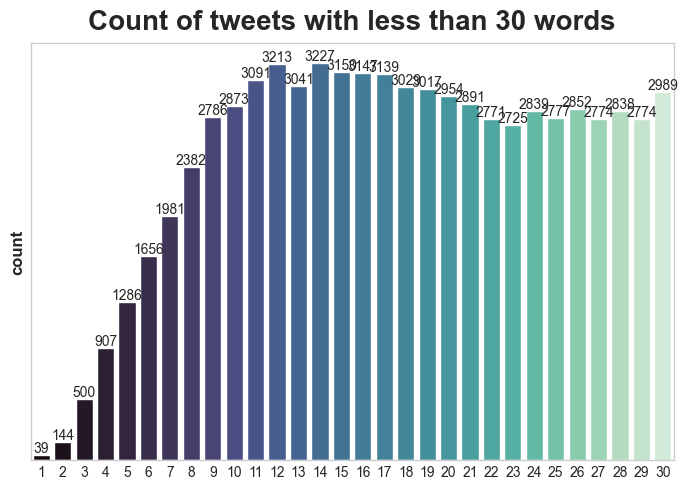

In [313]:
plt.figure(figsize=(7,5))
ax = sns.countplot(x='text_len', data=df[df['text_len']<=30], palette='mako')
plt.title('Count of tweets with less than 30 words', fontsize=20)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [314]:
df = df[df['text_len'] > 2]
df.sort_values(by=['text_len'], ascending=False)

,text,label,text_clean,text_len
57655,till date you were not able tell the name thos...,-1.0,till date abl tell name got loan waiver modi g...,51
126295,tufail why you always fail maybe you parents n...,1.0,tufail alway fail mayb parent name rightli hat...,50
13002,dear how long will cry etc full years you got ...,1.0,dear long cri etc full year got could move eve...,49
115917,sir all poor peoples are very suffering for da...,-1.0,sir poor peopl suffer daili use thing like mil...,49
116295,why did not vijaya mallya nirav modi and mehul...,1.0,vijaya mallya nirav modi mehul choksi run away...,49
...,...,...,...,...
77861,“modi’ greatest hits”,1.0,modi greatest hit,3
32410,pink too ‍♀️‍♀️,-1.0,pink,3
99277,nice modi keep,1.0,nice modi keep,3
61323,pro thanks modi,1.0,pro thank modi,3


/Users/srishti/Library/Python/3.10/lib/python/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


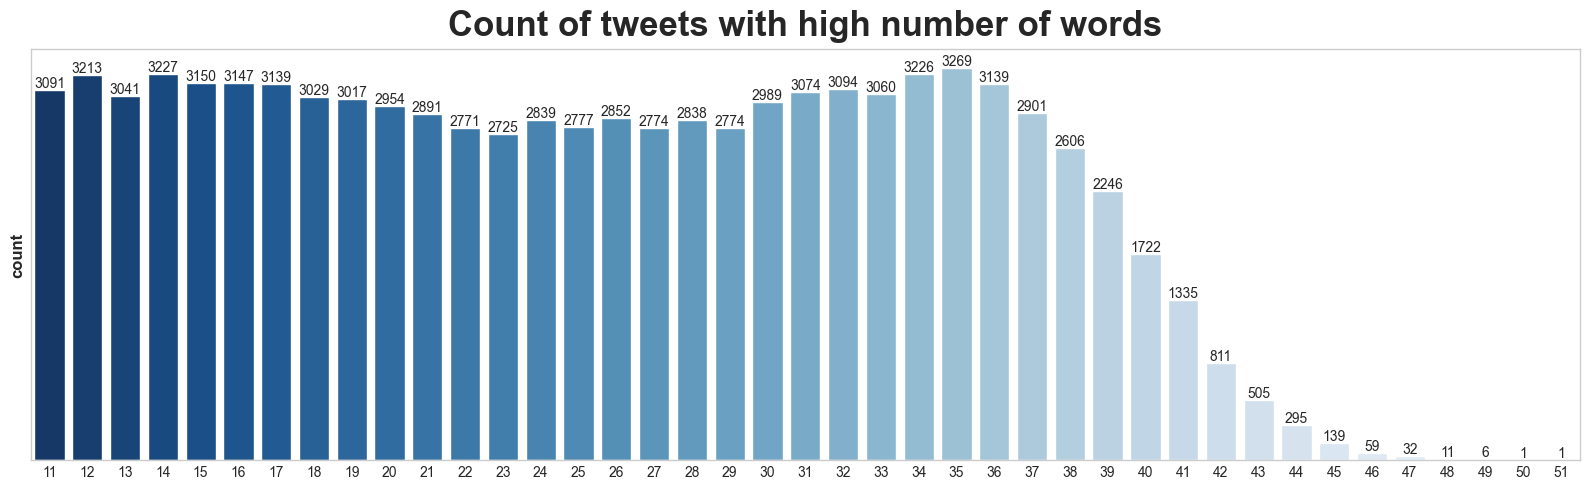

In [315]:
plt.figure(figsize=(16,5))
ax = sns.countplot(x='text_len', data=df[(df['text_len']<=100) & (df['text_len']>10)], palette='Blues_r')
plt.title('Count of tweets with high number of words', fontsize=25)
plt.yticks([])
ax.bar_label(ax.containers[0])
plt.ylabel('count')
plt.xlabel('')
plt.show()

In [316]:
df = df[df['text_len'] < 100]
max_len = np.max(df['text_len'])
print(max_len)
df.sort_values(by=["text_len"], ascending=False)


51


,text,label,text_clean,text_len
57655,till date you were not able tell the name thos...,-1.0,till date abl tell name got loan waiver modi g...,51
126295,tufail why you always fail maybe you parents n...,1.0,tufail alway fail mayb parent name rightli hat...,50
13002,dear how long will cry etc full years you got ...,1.0,dear long cri etc full year got could move eve...,49
115917,sir all poor peoples are very suffering for da...,-1.0,sir poor peopl suffer daili use thing like mil...,49
116295,why did not vijaya mallya nirav modi and mehul...,1.0,vijaya mallya nirav modi mehul choksi run away...,49
...,...,...,...,...
77861,“modi’ greatest hits”,1.0,modi greatest hit,3
32410,pink too ‍♀️‍♀️,-1.0,pink,3
99277,nice modi keep,1.0,nice modi keep,3
61323,pro thanks modi,1.0,pro thank modi,3


In [317]:
X = df['text']
y = df['label']

In [318]:
# find data types of each column
df.dtypes
# convert label to long 
df['label'] = df['label'].astype('int64')

In [319]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [320]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [321]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[-1.0000e+00,  2.5042e+04],
       [ 1.0000e+00,  5.0658e+04]])

In [322]:
ros = RandomOverSampler()
X_train, y_train = ros.fit_resample(np.array(X_train).reshape(-1, 1), np.array(y_train).reshape(-1, 1))
train_os = pd.DataFrame(list(zip([x[0] for x in X_train], y_train)), columns = ['text', 'label'])

In [323]:
X_train = train_os['text'].values
y_train = train_os['label'].values

In [324]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[-1.0000e+00,  5.0658e+04],
       [ 1.0000e+00,  5.0658e+04]])

In [325]:
def Tokenize(column, seq_len):
    ##Create vocabulary of words from column
    corpus = [word for text in column for word in text.split()]
    count_words = Counter(corpus)
    sorted_words = count_words.most_common()
    vocab_to_int = {w:i+1 for i, (w,c) in enumerate(sorted_words)}

    ##Tokenize the columns text using the vocabulary
    text_int = []
    for text in column:
        r = [vocab_to_int[word] for word in text.split()]
        text_int.append(r)
    ##Add padding to tokens
    features = np.zeros((len(text_int), seq_len), dtype = int)
    for i, review in enumerate(text_int):
        if len(review) <= seq_len:
            zeros = list(np.zeros(seq_len - len(review)))
            new = zeros + review
        else:
            new = review[: seq_len]
        features[i, :] = np.array(new)

    return sorted_words, features

In [326]:
max_len

51

In [327]:
vocabulary, tokenized_column = Tokenize(df["text"], max_len)

In [328]:
df["text"].iloc[16]

'\ndevelopment has become mass movement under modi govt with economic social and political empowerment life one and all has witnessed positive paradigm shift this new india'

In [329]:
tokenized_column[16]

array([   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
          0,    0,    0,  207,   13,  176, 1833, 1878,   89,    1,   35,
         12,  387,  454,    3,  140, 2767,  274,   37,    3,   16,   13,
       3962,  924, 6967, 2614,    9,   87,   11])

In [330]:
keys = []
values = []
for key, value in vocabulary[:5]:
    print(key, value)

modi 101441
the 78757
and 51584
for 38427
you 29130


In [331]:
for i , (key, value) in enumerate(vocabulary[:5]):
    print (i, key, value)

0 modi 101441
1 the 78757
2 and 51584
3 for 38427
4 you 29130


In [332]:
plt.figure(figsize=(15, 5))
ax = sns.barplot(x=keys, y=values, palette='mako')
plt.title('Top 20 most common words', size=25)
ax.bar_label(ax.containers[0])
plt.ylabel("Words count")
plt.show()

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/seaborn/categorical.py:638: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  vals = pd.Series(vals, index=index)


ValueError: min() arg is an empty sequence

<Figure size 1500x500 with 0 Axes>

In [333]:
Word2vec_train_data = list(map(lambda x: x.split(), X_train))


In [334]:
EMBEDDING_DIM = 200


In [335]:
word2vec_model = Word2Vec(Word2vec_train_data, vector_size=EMBEDDING_DIM)


In [336]:
print(f"Vocabulary size: {len(vocabulary) + 1}")


Vocabulary size: 92294


In [337]:
VOCAB_SIZE = len(vocabulary) + 1 #+1 for the padding


In [338]:
from tqdm import tqdm

In [339]:
#define empty embedding matrix

embedding_matrix = np.zeros((VOCAB_SIZE, EMBEDDING_DIM))
    
#fill the embedding matrix with the pre trained values from word2vec
#    corresponding to word (string), token (number associated to the word)
for i , (word, token) in enumerate(vocabulary):
    if word2vec_model.wv.__contains__(word):
        embedding_matrix[i] = word2vec_model.wv.__getitem__(word)

print("Embedding Matrix Shape:", embedding_matrix.shape)

Embedding Matrix Shape: (92294, 200)


In [356]:
df['label']=df['label'].replace(-1,0)

In [357]:
X = tokenized_column
y = df['label'].values

In [358]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=seed_value)

In [359]:
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, stratify=y_train, random_state=seed_value)

In [360]:
(unique, counts) = np.unique(y_train, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 25042],
       [    1, 50658]])

In [361]:
ros = RandomOverSampler()
X_train_os, y_train_os = ros.fit_resample(np.array(X_train),np.array(y_train));

In [362]:
(unique, counts) = np.unique(y_train_os, return_counts=True)
np.asarray((unique, counts)).T

array([[    0, 50658],
       [    1, 50658]])

In [363]:
train_data = TensorDataset(torch.from_numpy(X_train_os), torch.from_numpy(y_train_os))
test_data = TensorDataset(torch.from_numpy(X_test), torch.from_numpy(y_test))
valid_data = TensorDataset(torch.from_numpy(X_valid), torch.from_numpy(y_valid))

In [364]:
BATCH_SIZE = 32

In [365]:
train_loader = DataLoader(train_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True) 
valid_loader = DataLoader(valid_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)
test_loader = DataLoader(test_data, shuffle=True, batch_size=BATCH_SIZE, drop_last=True)

In [366]:
NUM_CLASSES = 5 #We are dealing with a multiclass classification of 5 classes
HIDDEN_DIM = 100 #number of neurons of the internal state (internal neural network in the LSTM)
LSTM_LAYERS = 1 #Number of stacked LSTM layers

LR = 3e-4 #Learning rate
DROPOUT = 0.5 #LSTM Dropout
BIDIRECTIONAL = True #Boolean value to choose if to use a bidirectional LSTM or not
EPOCHS = 5 #Number of training epoch

DEVICE = 'cpu'

In [367]:
sequence_length = 28
input_size = 28
hidden_size = 128
num_layers = 2 #2-layer stacked LSTM
num_classes = 10

In [368]:
class BiLSTM_Sentiment_Classifier(nn.Module):

    def __init__(self, vocab_size, embedding_dim, hidden_dim, num_classes, lstm_layers, bidirectional,batch_size, dropout):
        super(BiLSTM_Sentiment_Classifier,self).__init__()
        
        self.lstm_layers = lstm_layers
        self.num_directions = 2 if bidirectional else 1
        self.hidden_dim = hidden_dim
        self.num_classes = num_classes
        self.batch_size = batch_size
        

        self.embedding = nn.Embedding(vocab_size, embedding_dim)
        
        self.lstm = nn.LSTM(embedding_dim,
                            hidden_dim,
                            num_layers=lstm_layers,
                            dropout=dropout,
                            bidirectional=bidirectional,
                            batch_first=True)

        self.fc = nn.Linear(hidden_dim*self.num_directions, num_classes)
        self.softmax = nn.LogSoftmax(dim=1)
                
    def forward(self, x, hidden):
        self.batch_size = x.size(0)
        ##EMBEDDING LAYER
        embedded = self.embedding(x)
        #LSTM LAYERS
        out, hidden = self.lstm(embedded, hidden)
        #Extract only the hidden state from the last LSTM cell
        out = out[:,-1,:]
        #FULLY CONNECTED LAYERS
        out = self.fc(out)
        out = self.softmax(out)

        return out, hidden

    def init_hidden(self, batch_size):
        #Initialization of the LSTM hidden and cell states
        h0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        c0 = torch.zeros((self.lstm_layers*self.num_directions, batch_size, self.hidden_dim)).detach().to(DEVICE)
        hidden = (h0, c0)

In [369]:
class RNN(nn.Module):
    def __init__(self,input_size,hidden_size,num_layers,num_classes):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True) #batch_first for shape (batch,seq_no,features)
        self.fc = nn.Linear(hidden_size,num_classes)
    
    def forward(self,X_batch):
        hidden_0 = torch.zeros(self.num_layers, X_batch.size(0), self.hidden_size).to(DEVICE)
        cellstate_0 = torch.zeros(self.num_layers, X_batch.size(0),self.hidden_size).to(DEVICE)
        
        output,_ = self.lstm(X_batch, (hidden_0,cellstate_0))
        #output shape is (batch_size,seq_no,hidden_size)
        # we need hidden_state of the last element in the sequence for each of the batch inputs
        output = self.fc(output[:,-1,:])
        return output
    
    def train_step(self,X_batch):
        images,labels = X_batch
        images = images.reshape(-1,sequence_length,input_size)
        output = model(images)
        loss = F.cross_entropy(output,labels)
        return loss
    
    def test_step(self,X_batch):
        images,labels = X_batch
        images = images.reshape(-1,sequence_length,input_size)
        output = model(images)
        loss = F.cross_entropy(output,labels)
        _,preds = torch.max(output,dim=1)
        acc = torch.tensor(torch.sum(preds==labels).item()/len(preds))
        return {'loss':loss,'acc':acc}
    

In [370]:
model = BiLSTM_Sentiment_Classifier(VOCAB_SIZE, EMBEDDING_DIM, HIDDEN_DIM,NUM_CLASSES, LSTM_LAYERS,BIDIRECTIONAL, BATCH_SIZE, DROPOUT)
model = model.to(DEVICE)

#Initialize embedding with the previously defined embedding matrix
model.embedding.weight.data.copy_(torch.from_numpy(embedding_matrix))
#Allow the embedding matrix to be fined tuned to better adapt to out dataset and get higher accuracy
model.embedding.weight.requires_grad=True

print(model)

BiLSTM_Sentiment_Classifier(
  (embedding): Embedding(92294, 200)
  (lstm): LSTM(200, 100, batch_first=True, dropout=0.5, bidirectional=True)
  (fc): Linear(in_features=200, out_features=5, bias=True)
  (softmax): LogSoftmax(dim=1)
)


/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/torch/nn/modules/rnn.py:67: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn("dropout option adds dropout after all but last "


In [371]:
criterion = nn.NLLLoss()
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay = 5e-6)

In [372]:
total_step = len(train_loader)
total_step_val = len(valid_loader)

early_stopping_patience = 4
early_stopping_counter = 0

valid_acc_max = 0 # Initialize best accuracy top 0

for e in range(EPOCHS):

    #lists to host the train and validation losses of every batch for each epoch
    train_loss, valid_loss  = [], []
    #lists to host the train and validation accuracy of every batch for each epoch
    train_acc, valid_acc  = [], []

    #lists to host the train and validation predictions of every batch for each epoch
    y_train_list, y_val_list = [], []

    #initalize number of total and correctly classified texts during training and validation
    correct, correct_val = 0, 0
    total, total_val = 0, 0
    running_loss, running_loss_val = 0, 0


    ####TRAINING LOOP####

    model.train()

    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) #load features and targets in device

        h = model.init_hidden(labels.size(0))

        model.zero_grad() #reset gradients 

        output, h = model(inputs,h) #get output and hidden states from LSTM network
        
        loss = criterion(output, labels)
        loss.backward()
        
        running_loss += loss.item()
        
        optimizer.step()

        y_pred_train = torch.argmax(output, dim=1) #get tensor of predicted values on the training set
        y_train_list.extend(y_pred_train.squeeze().tolist()) #transform tensor to list and the values to the list
        
        correct += torch.sum(y_pred_train==labels).item() #count correctly classified texts per batch
        total += labels.size(0) #count total texts per batch

    train_loss.append(running_loss / total_step)
    train_acc.append(100 * correct / total)

    ####VALIDATION LOOP####
    
    with torch.no_grad():
        
        model.eval()

        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)

            val_h = model.init_hidden(labels.size(0))

            output, val_h = model(inputs, val_h)

            val_loss = criterion(output, labels)
            running_loss_val += val_loss.item()

            y_pred_val = torch.argmax(output, dim=1)
            y_val_list.extend(y_pred_val.squeeze().tolist())

            correct_val += torch.sum(y_pred_val==labels).item()
            total_val += labels.size(0)

        valid_loss.append(running_loss_val / total_step_val)
        valid_acc.append(100 * correct_val / total_val)

    #Save model if validation accuracy increases
    if np.mean(valid_acc) >= valid_acc_max:
        torch.save(model.state_dict(), './state_dict.pt')
        print(f'Epoch {e+1}:Validation accuracy increased ({valid_acc_max:.6f} --> {np.mean(valid_acc):.6f}).  Saving model ...')
        valid_acc_max = np.mean(valid_acc)
        early_stopping_counter=0 #reset counter if validation accuracy increases
    else:
        print(f'Epoch {e+1}:Validation accuracy did not increase')
        early_stopping_counter+=1 #increase counter if validation accuracy does not increase
        
    if early_stopping_counter > early_stopping_patience:
        print('Early stopped at epoch :', e+1)
        break

    print(f'\tTrain_loss : {np.mean(train_loss):.4f} Val_loss : {np.mean(valid_loss):.4f}')
    print(f'\tTrain_acc : {np.mean(train_acc):.3f}% Val_acc : {np.mean(valid_acc):.3f}%')

Epoch 1:Validation accuracy increased (0.000000 --> 91.674618).  Saving model ...
	Train_loss : 0.4022 Val_loss : 0.2161
	Train_acc : 80.382% Val_acc : 91.675%
Epoch 2:Validation accuracy increased (91.674618 --> 92.378340).  Saving model ...
	Train_loss : 0.1094 Val_loss : 0.1909
	Train_acc : 96.131% Val_acc : 92.378%
Epoch 3:Validation accuracy increased (92.378340 --> 92.497615).  Saving model ...
	Train_loss : 0.0518 Val_loss : 0.2195
	Train_acc : 98.281% Val_acc : 92.498%
Epoch 4:Validation accuracy increased (92.497615 --> 92.700382).  Saving model ...
	Train_loss : 0.0284 Val_loss : 0.2221
	Train_acc : 99.091% Val_acc : 92.700%
Epoch 5:Validation accuracy did not increase
	Train_loss : 0.0168 Val_loss : 0.2621
	Train_acc : 99.461% Val_acc : 92.665%
